In [96]:
!mkdir utils

In [97]:
!git clone https://gist.github.com/pchlq/17e5275bf5bbdf81e89e93241ad93ce5 utils/

Клонирование в «utils»…
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 15
Распаковка объектов: 100% (18/18), готово.


In [2]:
!python -V

Python 3.7.4


# Load packs

In [98]:
import pandas as pd
import numpy as np
from utils import dataset as fn
import json
import glob
from dateutil.parser import parse
import itertools
import gc
gc.enable()
from pathlib import Path
import pickle
from collections import Counter, defaultdict

from featexp import get_univariate_plots
from featexp import univariate_plotter
from featexp import get_trend_stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix

from IPython.display import display_html
from contextlib import contextmanager
import time
from scipy.special import boxcox1p
from scipy import stats

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, RepeatedKFold,
                                     ShuffleSplit, StratifiedKFold, TimeSeriesSplit)
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance, plot_metric
import xgboost as xgb

from numba import jit
from sklearn import metrics
import lightgbm as lgb

from sklearn.pipeline import Pipeline as pipe
from sklearn_pandas import DataFrameMapper
from copy import deepcopy
import concurrent.futures
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt
from feature_engine import outlier_removers as outr
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

pd.set_option('display.max_columns', 150)

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [80]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
    
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    

def tree_based_model_compare(X, y, cv, seed, score='roc_auc'):
    
    model_rf = RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                max_depth=None, random_state=seed)
    model_lgb = LGBMClassifier(random_state=seed)
    model_xgb = xgb.XGBClassifier(random_state=seed)
    model_cat = CatBoostClassifier(random_state=seed, silent=True)
 
    with timer('RandomForestClassifier...'):
        cv_scores_rf = cross_val_score(model_rf, X, y, cv=cv, scoring=score)

    with timer('LGBMClassifier...'): 
        cv_scores_lgb = cross_val_score(model_lgb, X, y, cv=cv, scoring=score, n_jobs=-1)
        
    with timer('XGBClassifier...'):
        cv_scores_xgb = cross_val_score(model_xgb, X, y, cv=cv, scoring=score, n_jobs=-1)
    
    with timer('CatBoostClassifier...'):
        cv_scores_cat = cross_val_score(model_cat, X, y, cv=cv, scoring=score, n_jobs=-1)
    
    cv_results = pd.DataFrame(data={'RF': cv_scores_rf, 
                                    'LGB':cv_scores_lgb, 
                                    'XGB':cv_scores_xgb, 
                                    'CAT':cv_scores_cat})
    
    return display_side_by_side(cv_results, cv_results.describe())

def create_partial_df_all(train, cols, test):
    used_cols = [col for col in test.columns if col in cols]
    df_all = pd.concat([ train[used_cols],
                         test[used_cols] ])
    return (df_all.reset_index(drop=True))

def diagnostic_plots(df, variable):
    """
    func to plot a histogram and a Q-Q plot
    side by side, for a certain variable
    """
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.suptitle(variable)
    plt.show()
    
def box_cox_transform(data, num_col=None):
    """
    Box Cox Transformation of (highly: > 0.75) skewed features
    """
    if not num_col:
        num_col = data.columns
    df = data.copy()
    skewed_feats = df[num_col].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    
    skewness = pd.DataFrame({'Skew': skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    print(f"There are {skewness.shape[0]} skewed numerical features to Box Cox transform {skewness.index}")
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], lam)
        
    return (df)

def drop_corr_cols(df, upper_tresh=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > upper_tresh)]

    return to_drop

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


SEED = 100
TEST_SIZE = 0.3
SPLITS = 5

# ==== cv strategy ====
skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=SEED)
ts = TimeSeriesSplit()

In [121]:
def cnt_groups(data: pd.DataFrame,
               gr: list,
               colname: str
              ) -> pd.DataFrame:
    
    tmp=data.groupby(gr).size().reset_index().rename(columns={0: colname})                                         
    df=data.reset_index().merge(tmp, how='left', on=gr)#.fillna(-1)
    return (df.set_index("Time"))

def make_stats_features(df: pd.DataFrame,
                        group_col: list,
                        used_col: str,
                        prefix: str
                       ) -> pd.DataFrame:
    """
    Count stats: mean, std
    """
    tmp = df.groupby(group_col)[used_col].agg({np.mean, np.std}).fillna(0)
    tmp.columns = [prefix +'_'+ str(x) for x in tmp.columns]
    tmp = tmp.reset_index()
    tmp = tmp[tmp.columns[tmp.nunique()>1]]
    df = df.reset_index().merge(tmp, on=group_col, how="left")
    return (df.set_index("Time"))


def make_conj(df, feat1, feat2):
    """
    
    """
    data = df.copy()
    new_name = feat1 + '_' + feat2
    data[new_name] = data[feat1].astype(str)+ '_' + data[feat2].astype(str)
    data[new_name] = LabelEncoder().fit_transform(data[new_name])
    return (data)

def make_harmonic_features(df: pd.DataFrame,
                           column: list
                          ) -> pd.DataFrame:
    """
    For periodic feats
    """
    
    for col in column:
        period = df[col].nunique()
        value = df[col].copy()
        value *= 2 * np.pi / period
        df[col + '_cos'] = np.cos(value, dtype='float32')
        df[col + '_sin'] = np.sin(value, dtype='float32')
    return (df)


def plot_kde(df: pd.DataFrame,
             var: str,
             target: str = "Target",
             **kwargs: str
            ) -> plt:
    
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (df[var].min(), df[var].max()))
    facet.add_legend()
    plt.show()
    
    
def plot_roc(y_true, y_proba):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
    auc = metrics.roc_auc_score(y_true, y_proba)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr,tpr,label=f"data 1, auc={auc:.4f}")
    plt.legend(loc=4)
    plt.show()
    
    
def plot_target_distribution(df: pd.DataFrame,
                             cols_to_drop: list,
                             target: str,
                             title: str,
                             color_0: str = '#770000',
                             color_1: str = '#007700'
                            ) -> plt:
    
    cols=list(filter(lambda x: x not in cols_to_drop, df.columns))
    plt.figure(figsize=[18,8])
    for i, col in enumerate(cols):
        n_unique = df[col].nunique()
        cl = 3
        rw = np.ceil(df.shape[1] / cl).astype(int)
        ax = plt.subplot(rw, cl, i+1)
        bins_cnt = 30 if n_unique>30 else n_unique
        df.loc[df['Target']==0][col].hist(color=color_0, bins=bins_cnt , alpha=.5)
        df.loc[df['Target']==1][col].hist(color=color_1, bins=bins_cnt, alpha=.5)
        ax.set_title(f"{str(col)}, n_unique: {n_unique}", fontsize=15)
        ax.set_yscale('log')
        ax.legend(['0', '1'])

    plt.suptitle(title, y=1.05, fontsize=20)    
    plt.tight_layout();
    
PATH_TO_DATA = Path('data')

In [4]:
# use_col = lambda col: col not in ["Id"]

df = pd.read_csv("data/train.csv", index_col="Time", parse_dates=True)
dft = pd.read_csv("data/test.csv", index_col="Time", parse_dates=True)

df.sort_index(inplace=True)
dft.sort_index(inplace=True)

# add official holidays in Russia
    # Source: https://github.com/d10xa/holidays-calendar
# fl_json = glob.glob("data/consultant*.json")

# holidays_list = []
# for fl  in sorted(fl_json):
#     with open(fl) as f:
#         d = json.load(f)
#         holidays_list.append(d)

# parse_date = lambda x: parse(x).date()
# train_holidays = list(map(parse_date, 
#                         # combine dates of 2017 and 2018 ys
#                         list( itertools.chain(*[days['holidays'] for days in holidays_list[:-1]]) ) ))

# test_holidays = list( map(parse_date, holidays_list[-1]['holidays']) )

# train_holidays_bins = lambda x: 1 if x in train_holidays else 0
# df['is_holiday'] = df.index.map(train_holidays_bins)

# test_holidays_bins = lambda x: 1 if x in test_holidays else 0
# dft['is_holiday'] = dft.index.map(test_holidays_bins)

df = fn.reduce_mem_usage(df)
dft = fn.reduce_mem_usage(dft)

Mem. usage decreased to  7.04 Mb (64.1% reduction)
Mem. usage decreased to  0.97 Mb (60.7% reduction)


In [96]:
df[:3]

,Id,ClientID,ClientType,CoachID,GymID,TrainingID,Target
Time,,,,,,,
2017-01-01 08:00:00,113828,10962,2,495,1,847,1
2017-01-01 08:00:00,46246,63159,2,71,0,840,1
2017-01-01 08:00:00,43829,60091,1,523,0,1564,1


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321167 entries, 2017-01-01 08:00:00 to 2018-12-30 15:30:00
Data columns (total 7 columns):
Id            321167 non-null int32
ClientID      321167 non-null int32
ClientType    321167 non-null int8
CoachID       321167 non-null int16
GymID         321167 non-null int8
TrainingID    321167 non-null int16
Target        321167 non-null int8
dtypes: int16(2), int32(2), int8(3)
memory usage: 7.0 MB


Target distribution:
1    0.95961
0    0.04039
Name: Target, dtype: float64


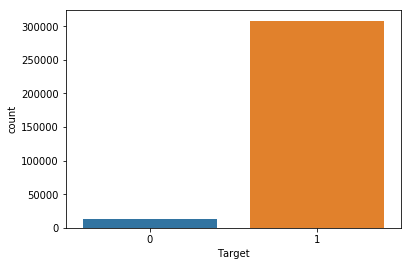

In [98]:
print("Target distribution:")
print(df.Target.value_counts(normalize=True))
sns.countplot(df.Target);

In [117]:
display_side_by_side( pd.DataFrame(df.drop("Target", axis=1).nunique(), columns=["train_df"]), 
                      pd.DataFrame(dft.nunique(), columns=["test_df"]) )

,train_df
Id,321167
ClientID,12969
ClientType,3
CoachID,313
GymID,7
TrainingID,913
,test_df
Id,46259
ClientID,13314
ClientType,3


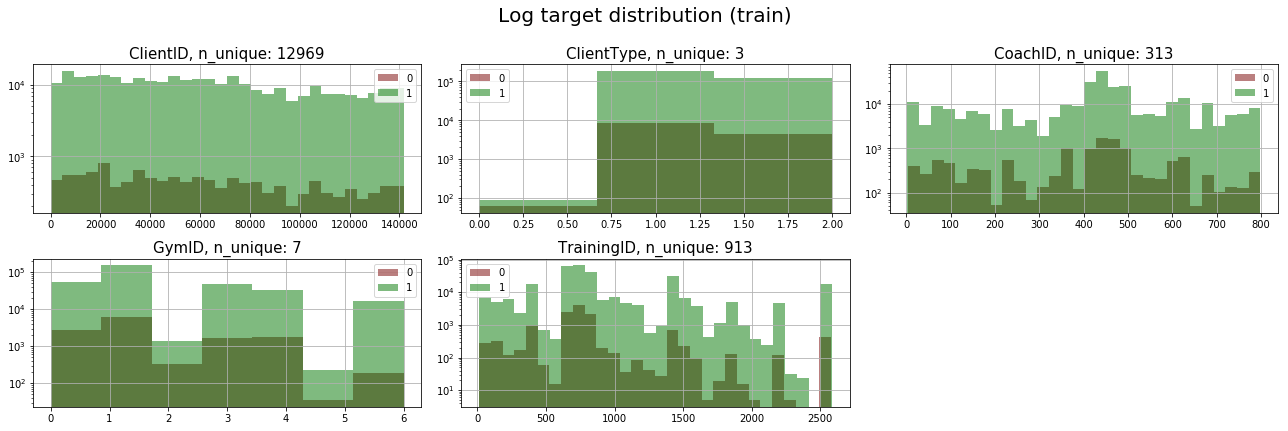

In [118]:
plot_target_distribution(df, cols_to_drop=["Target", "Id"], target="Target", title='Log target distribution (train)');

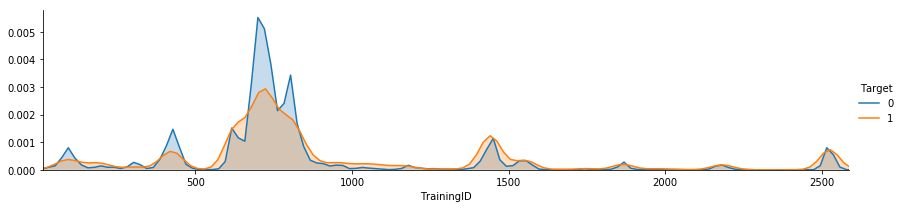

In [119]:
plot_kde(df, "TrainingID");

68889

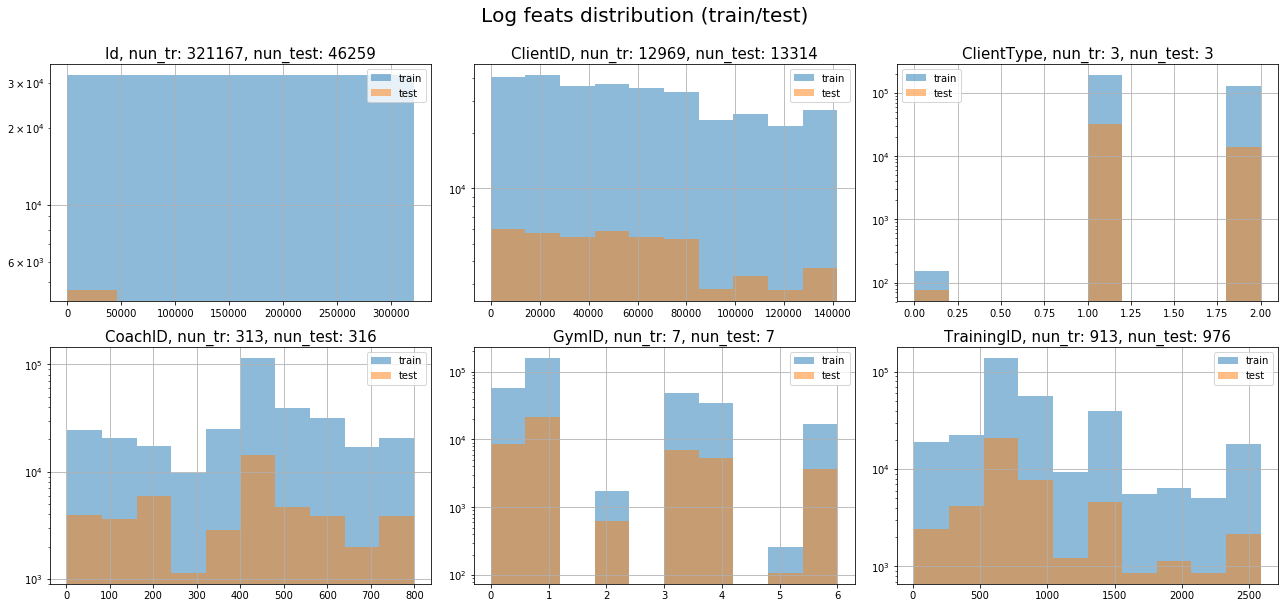

In [121]:
target = df.Target
df_all = pd.concat([df.loc[:, dft.columns], dft])
df_all.shape

plt.figure(figsize=[18,8])
for i, col in enumerate(df_all.columns):
    nun_tr = df[col].nunique()
    nun_test = dft[col].nunique()
    cl = 3
    rw = np.ceil(df_all.shape[1] / cl).astype(int)
    ax = plt.subplot(rw, cl, i+1)
    df[col].hist(alpha=.5)
    dft[col].hist(alpha=.5)
    ax.set_title(f"{str(col)}, nun_tr: {nun_tr}, nun_test: {nun_test}", fontsize=15)
    ax.set_yscale('log')
    ax.legend(['train', 'test'])

plt.suptitle('Log feats distribution (train/test)', 
             y=1.05,  fontsize=20)    
plt.tight_layout();

# Generate some features

In [5]:
def create_order_feat(data, by_col):
    
    df = data.copy()
    tmp = df.reset_index()[['Time', by_col]].copy()

    tmp = tmp.sort_values(by=[by_col, "Time"])
    tmp['range'] = np.arange(len(tmp))
    tmp2 = tmp[by_col].map(tmp.groupby(by_col).range.min()).values
    tmp3 = (tmp[by_col].map(tmp.groupby(by_col).range.max()) - tmp2 + 1).values
    
    col_ord_of_vis = "order_of_visits_"+by_col
    tmp.loc[:, col_ord_of_vis] = tmp['range'] - tmp2
    tmp.loc[:, "invert_order_of_visits_"+by_col] = tmp3 - tmp[col_ord_of_vis].values
    tmp.loc[:, "pct_order_"+by_col] = tmp[col_ord_of_vis] / tmp[by_col].map(tmp.groupby(by_col).range.max())
    
    new_cols = [i +'_'+ by_col for i in ["order_of_visits", "invert_order_of_visits", "pct_order"]]
    df = pd.concat([df.reset_index().sort_values(by=["Time", by_col]), 
                   tmp.drop('range', axis=1).sort_values(by=["Time", by_col])[new_cols]], axis=1).set_index("Time")
    del tmp, tmp2, tmp3
    gc.collect()
    return (df)

def gen_feats(data):
    """
    ctn -> count
    pct -> % / 100
    """
#     test["Target"] = 999
#     df = pd.concat([train, test]).copy()
    df = data.copy()
    
    # simple datetime feats ===========
#     df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["week"] = df.index.week
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
#     df["day"] = ((df.hour <= 19) & (df.hour >= 7)).astype('int').values
    
    # numeric feats related with grouping ClientID =======
    df["cnt_visits"] = df["ClientID"].map( df["ClientID"].value_counts() )
    df["cnt_gyms_per_client"] = df["ClientID"].map( df.groupby("ClientID")["GymID"].nunique() )
    df["cnt_coach_per_client"] = df["ClientID"].map( df.groupby("ClientID")["CoachID"].nunique() )
    df["cnt_traintype_per_client"] = df["ClientID"].map( df.groupby("ClientID")["TrainingID"].nunique() )
       
    # order_of_visits, invert_order_of_visits, pct_order =======
    df = create_order_feat(df, 'ClientID')
#     df = create_order_feat(df, 'CoachID')
        
    # days_before_last_train ========
    tmp = df.reset_index().sort_values(by=["ClientID", "Time"])[["ClientID", "Time"]].copy()
    gr = tmp.groupby("ClientID")

    diff_days_fn = lambda x: np.round(x.diff().fillna(pd.Timedelta(seconds=0)) / np.timedelta64(1,'D'))
    new_cols = ["cnt_days_before_last_train"]
    tmp[new_cols] = gr.pipe(diff_days_fn)
    df = pd.concat([df.reset_index().sort_values(by=["Time", "ClientID"]), 
                    tmp.sort_values(by=["Time", "ClientID"])[new_cols]], axis=1).set_index("Time")
       
    # ===============
    df["date"] = df.index.to_period("D")
    df = cnt_groups(df, ["ClientID", "date"], "cnt_train_per_day")
       
    #  ==============
    df["time"] = df.index.strftime("%H:%M:%S")
    df = cnt_groups(df, ["time", "GymID"], "cnt_groups_gymID_time")
    df["time_value_cnt"] = df.time.map(df.time.value_counts())
    
    df["cnt_ClientType_per_coach"] = df.CoachID.map(df.groupby("CoachID")["ClientType"].nunique())
    df["cnt_coaches_per_gym"] = df.GymID.map(df.groupby("GymID")["CoachID"].nunique()).values
    df["cnt_clients_per_gym"] = df.GymID.map(df.groupby("GymID")["ClientID"].nunique()).values
#     df["pct_clients_per_gym"] = cnt_clients_per_gym / cnt_clients_per_gym
    
    # weekly average and std of client's training =====
#     df['year'] = df.index.year
#     df["year_month"] = pd.Series(df.index).apply(lambda t: 100 * t.year + t.month).values / 1e5
    df = make_stats_features(df, group_col=['ClientID', 'week'], used_col='cnt_train_per_day', prefix='client_weektrain')
     
    # additional feats
    df["is_weekend"] = (df.dow.isin([5, 6])*1)
    df["pct_client_train_weekend"] = df.ClientID.map( df.groupby("ClientID").is_weekend.sum() ).values / df.cnt_visits
    
    df = make_conj(df, 'dow', 'hour')
#     df = make_conj(df, 'CoachID', 'TrainingID')

    most_freq_dayhour_fn = lambda x: x.dow_hour.value_counts().index[0]
    df["most_freq_dowhour_cnt"] = df.ClientID.map(df.groupby('ClientID').apply( most_freq_dayhour_fn) ).values
    
    cols_to_drop = ['date', 'time', 'is_weekend'] # 'ClientID', 'Id'
    df = df.drop(cols_to_drop, axis=1).reset_index(drop=True)
    
    del tmp
    gc.collect()
    df = fn.reduce_mem_usage(df)
    
    # train/test split df_all ======
    print("df shape: ", df.shape)
    print("new feats: ", df.shape[1] - data.shape[1])

    
    return df

In [6]:
%%time
train_df = gen_feats(df)

Mem. usage decreased to 24.81 Mb (59.3% reduction)
df shape:  (321167, 30)
new feats:  23
CPU times: user 29.3 s, sys: 164 ms, total: 29.5 s
Wall time: 27.7 s


In [7]:
%%time
test_df = gen_feats(dft)

Mem. usage decreased to  3.40 Mb (61.1% reduction)
df shape:  (46259, 29)
new feats:  23
CPU times: user 22.3 s, sys: 33.7 ms, total: 22.3 s
Wall time: 20.9 s


In [8]:
del df, dft#, df_all
gc.collect()

22

In [220]:
train_df[:3]

,Id,ClientID,ClientType,CoachID,GymID,TrainingID,Target,month,week,dow,hour,cnt_visits,cnt_gyms_per_client,cnt_coach_per_client,cnt_traintype_per_client,order_of_visits_ClientID,invert_order_of_visits_ClientID,pct_order_ClientID,cnt_days_before_last_train,cnt_train_per_day,cnt_groups_gymID_time,time_value_cnt,cnt_ClientType_per_coach,cnt_coaches_per_gym,cnt_clients_per_gym,client_weektrain_std,client_weektrain_mean,pct_client_train_weekend,dow_hour,most_freq_dowhour_cnt
0,113828,10962,2,495,1,847,1,1,52,6,8,74,2,18,26,0,74,0.0,0.0,1,4831,10303,2,84,7233,0.000000,1.0,0.283784,132,25
1,24306,33441,2,270,3,840,1,1,52,6,8,184,1,16,29,0,184,0.0,0.0,2,1686,10303,2,67,2030,0.000000,2.0,0.364130,132,27
2,43829,60091,1,523,0,1564,1,1,52,6,8,609,1,8,3,0,609,0.0,0.0,1,1987,10303,2,47,2719,0.516398,1.5,0.218391,132,17


# Some interesting insights

                                    Plots for cnt_gyms_per_client                                     


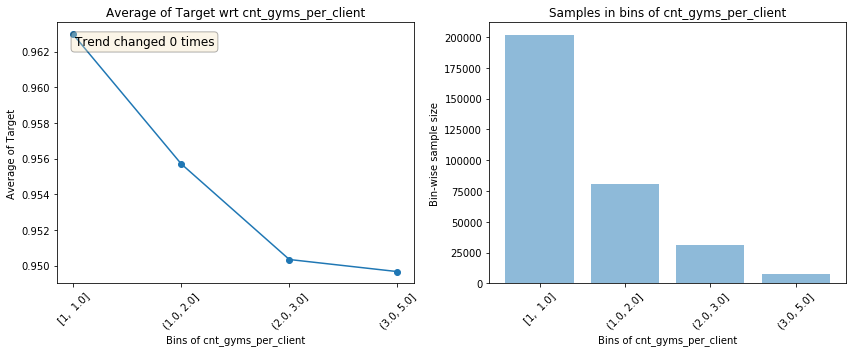

--------------------------------------------------------------------------------------------------------------


                                         Plots for cnt_visits                                         


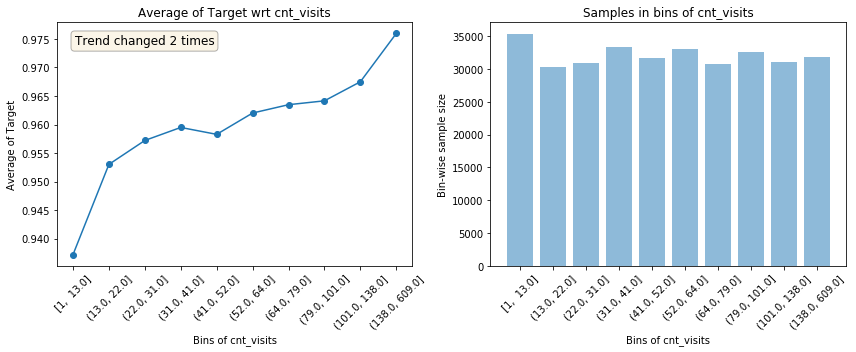

--------------------------------------------------------------------------------------------------------------


                                            Plots for hour                                            


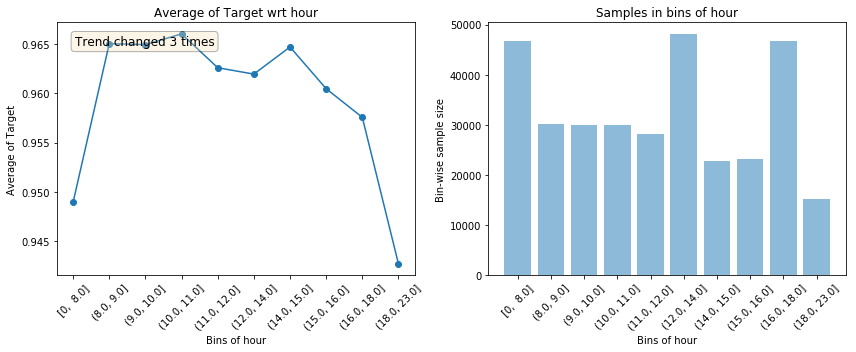

--------------------------------------------------------------------------------------------------------------


                                            Plots for dow                                             


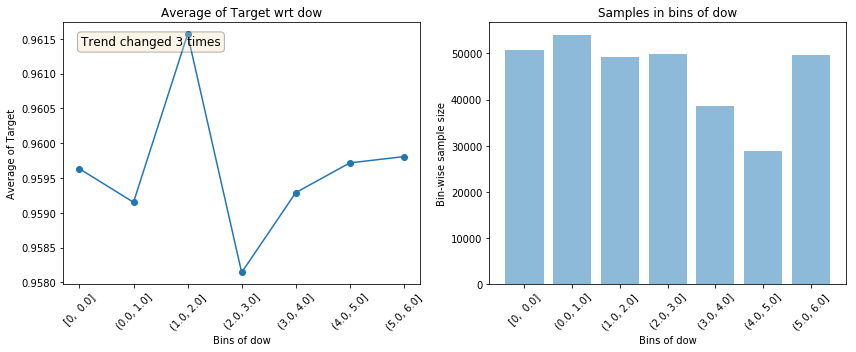

--------------------------------------------------------------------------------------------------------------


                                 Plots for cnt_days_before_last_train                                 


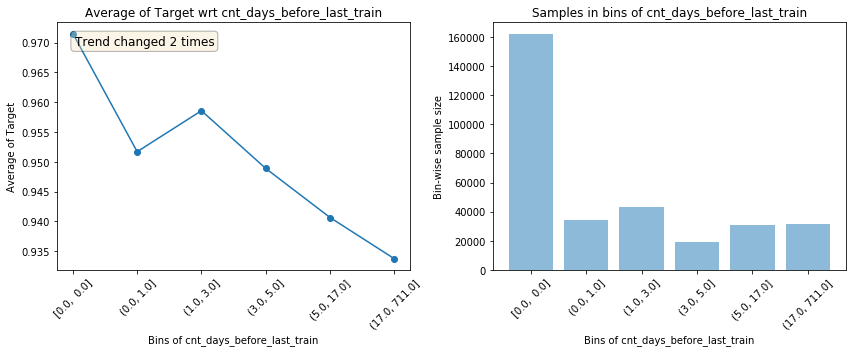

--------------------------------------------------------------------------------------------------------------


                                     Plots for cnt_train_per_day                                      


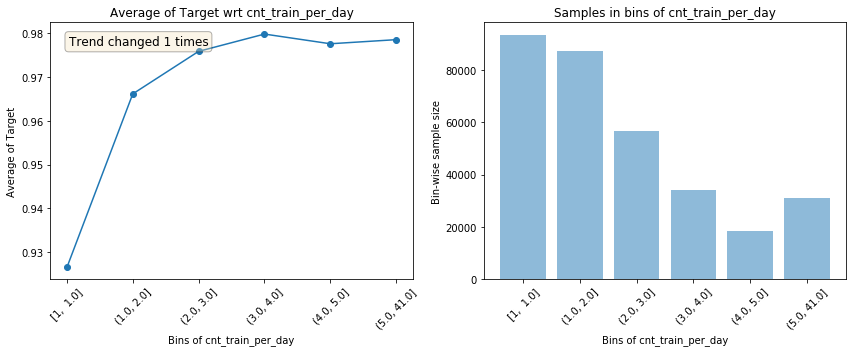

--------------------------------------------------------------------------------------------------------------




In [86]:
get_univariate_plots(data=train_df, target_col='Target', 
                     features_list=['cnt_gyms_per_client', 'cnt_visits', 'hour', 'dow', 'cnt_days_before_last_train', 'cnt_train_per_day'])

In [31]:
# numeric feats
real_feats = train_df.filter(regex='(cnt|pct|order|std|mean)').columns.tolist()
# cat feats
cat_feats = train_df.columns.difference(real_feats + ['ClientID', 'Target', 'Id']).to_list()

## Numerical feats

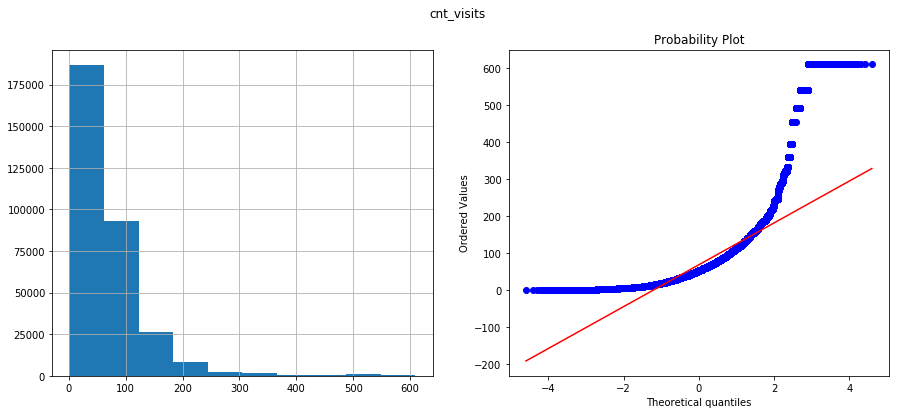

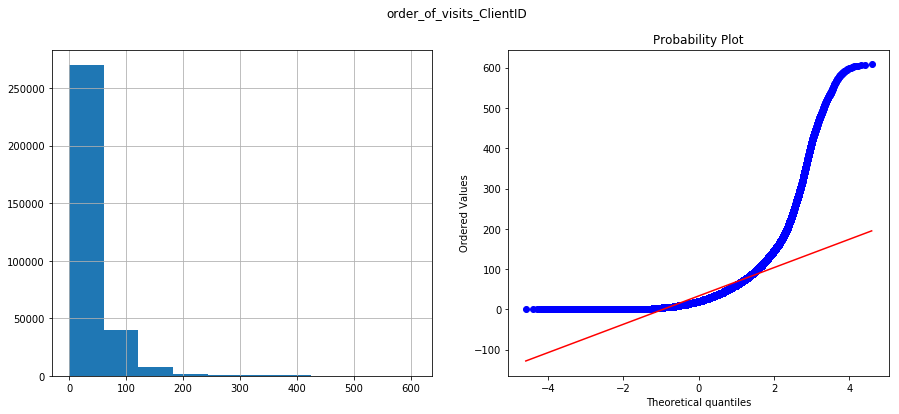

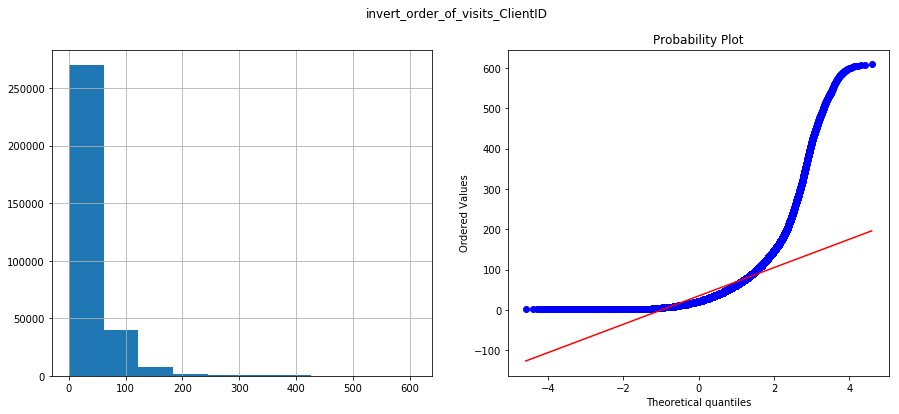

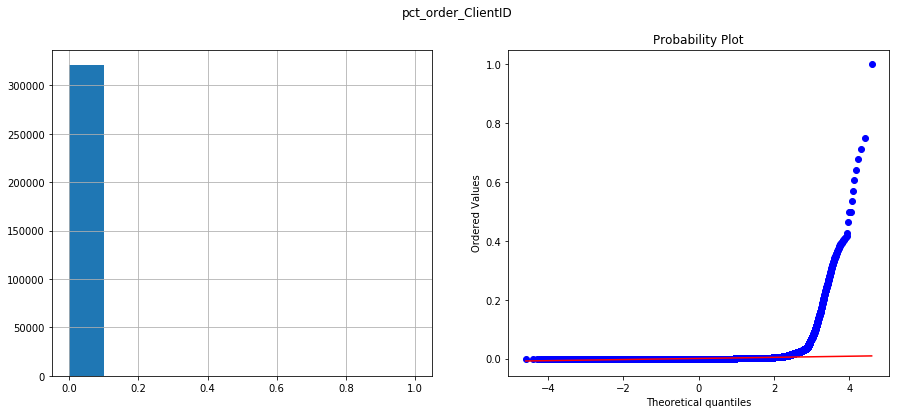

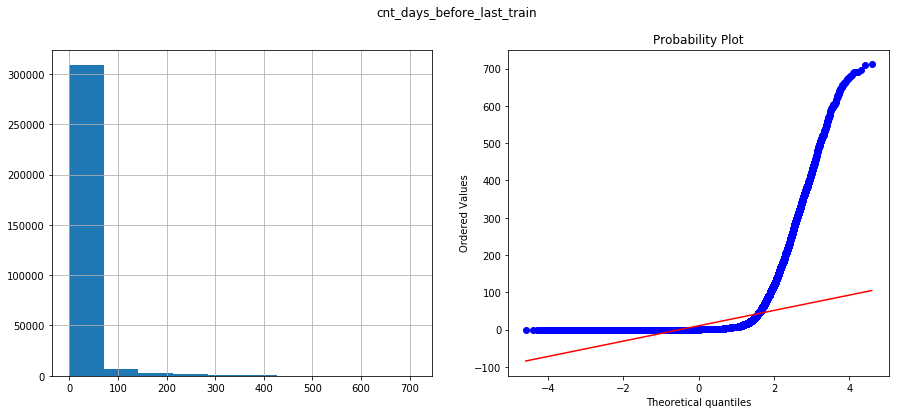

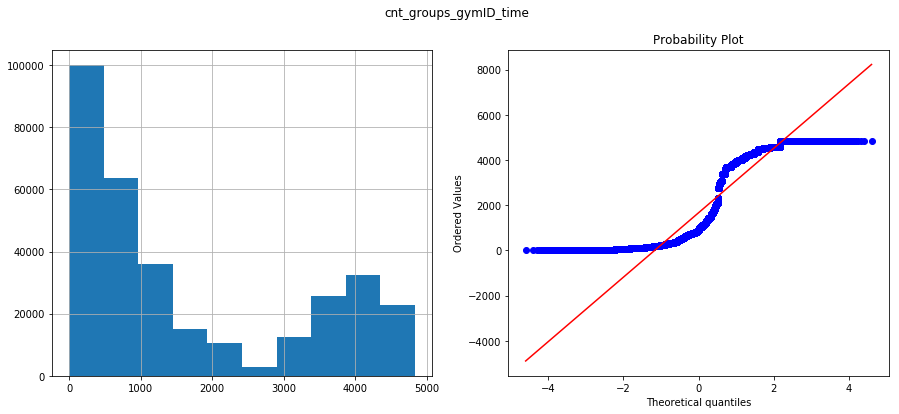

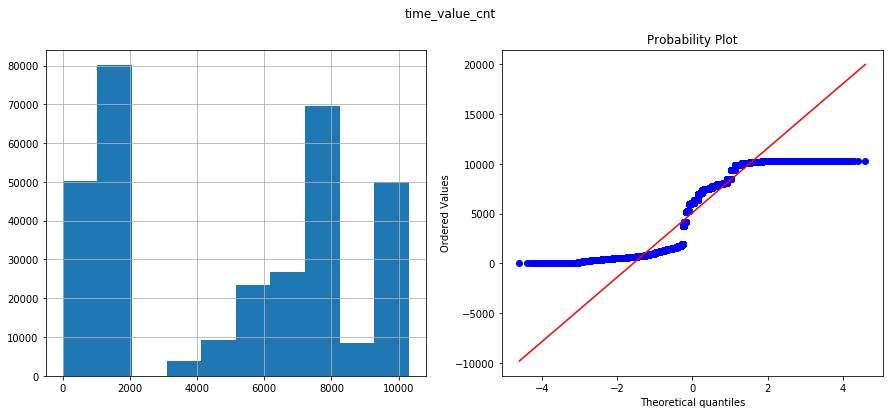

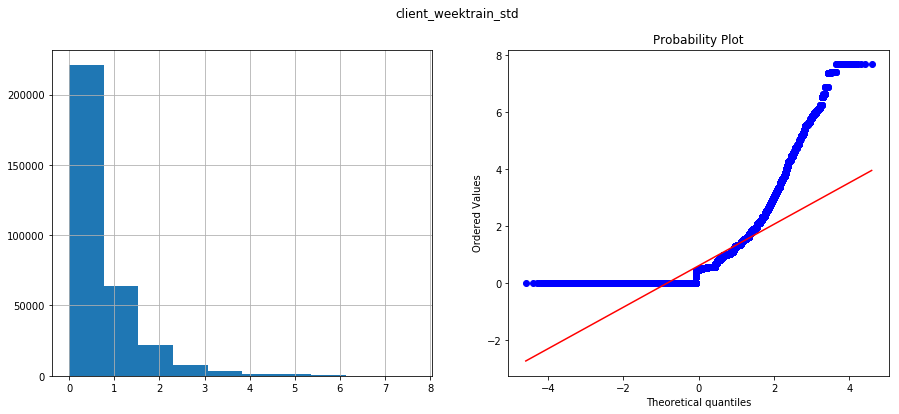

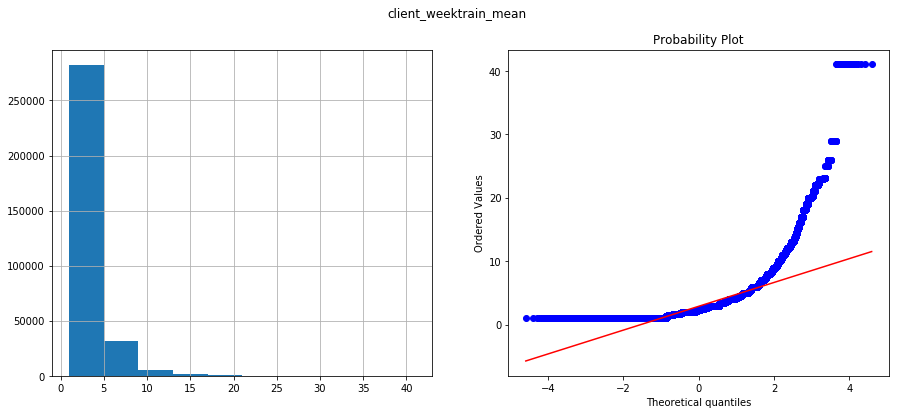

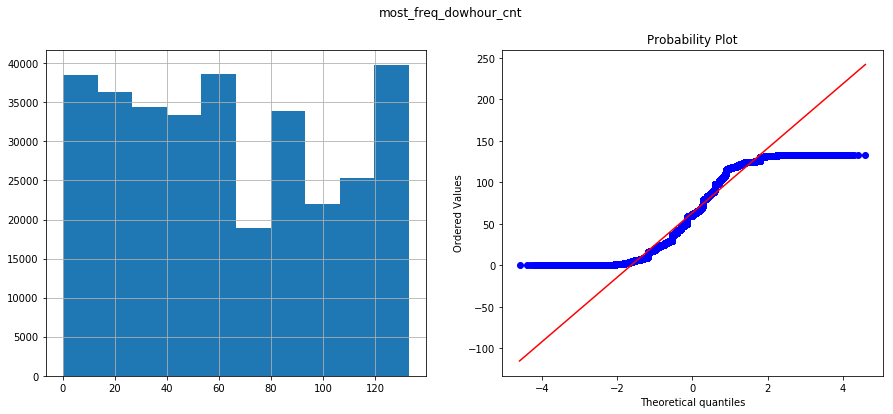

In [136]:
cols = [col for col in real_feats if train_df[col].nunique()>100]
for var in cols:
    diagnostic_plots(train_df, var)

In [32]:
df_all_numeric = create_partial_df_all(train_df, real_feats, test_df)

In [153]:
df_logtransform = df_all_numeric.apply(np.log1p).copy()

display_side_by_side( pd.DataFrame({"Skewness": df_all_numeric.apply(lambda x: stats.skew(x)).sort_values(ascending=False)}),
                     pd.DataFrame({"Box-cox transformation": df_boxcox.apply(lambda x: stats.skew(x)).sort_values(ascending=False)}),
                     pd.DataFrame({"Log-transformation": df_logtransform.apply(lambda x: stats.skew(x)).sort_values(ascending=False)}) )

,Skewness
pct_order_ClientID,43.348747
cnt_days_before_last_train,7.195935
order_of_visits_ClientID,4.052513
invert_order_of_visits_ClientID,4.052513
client_weektrain_mean,3.743264
cnt_train_per_day,3.501572
cnt_visits,3.257071
client_weektrain_std,2.469042
cnt_gyms_per_client,1.618158
cnt_groups_gymID_time,0.908255


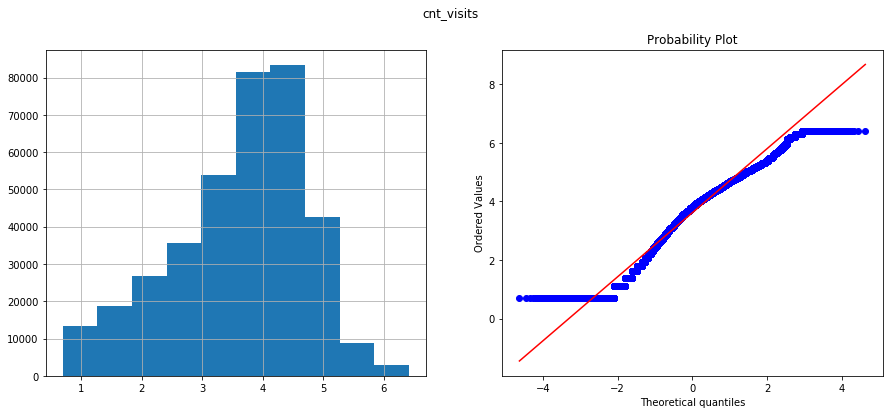

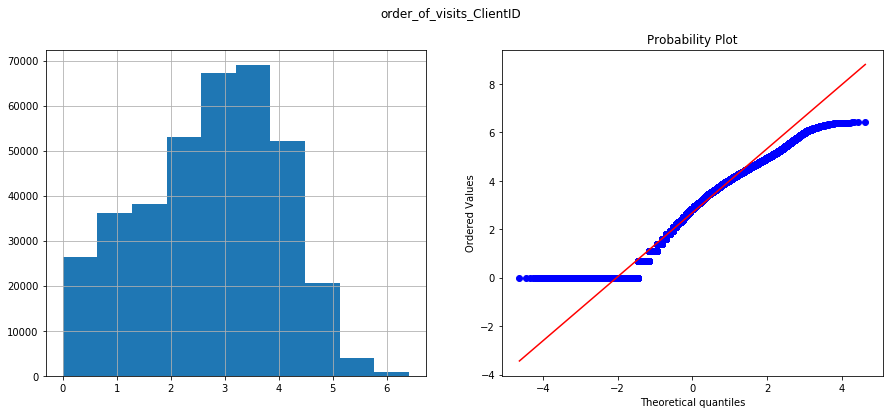

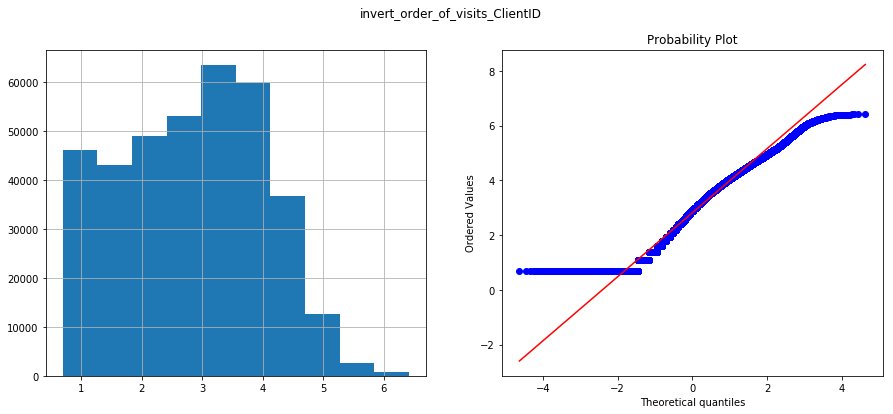

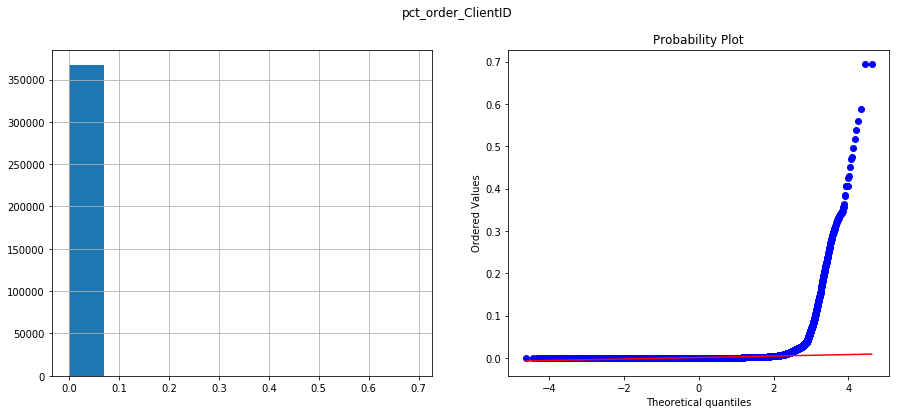

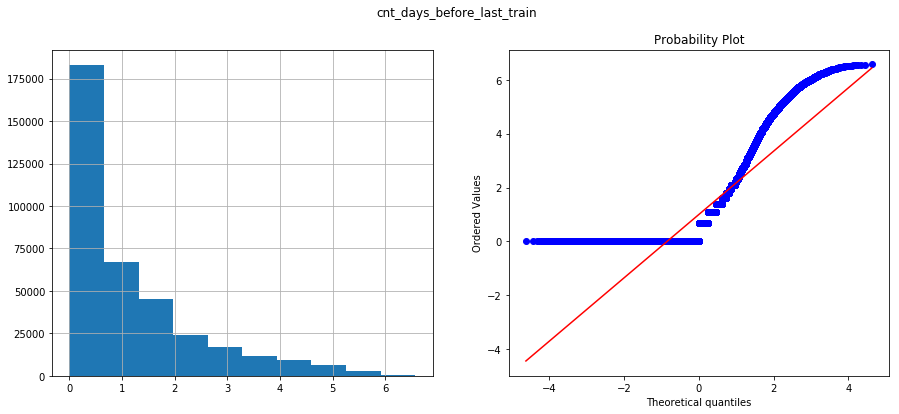

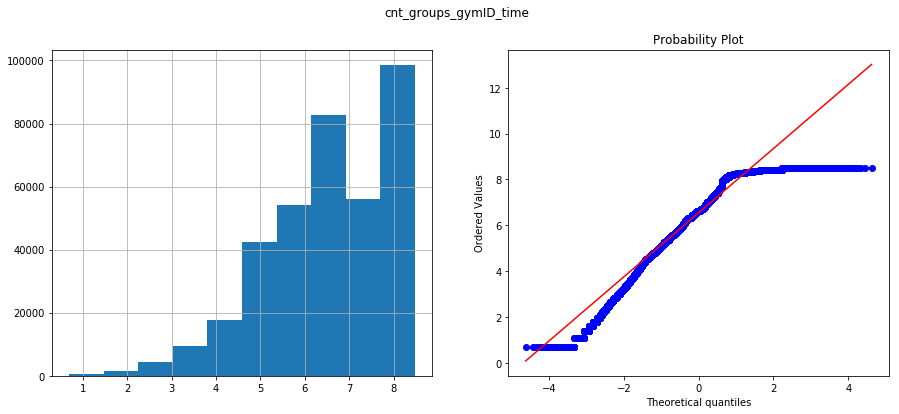

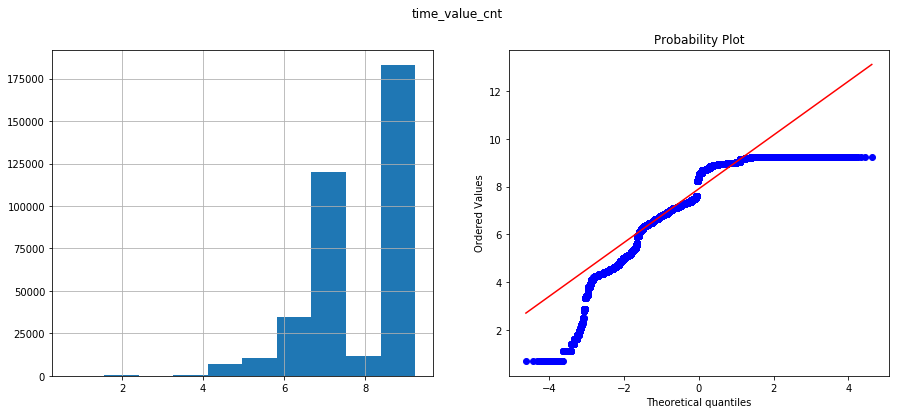

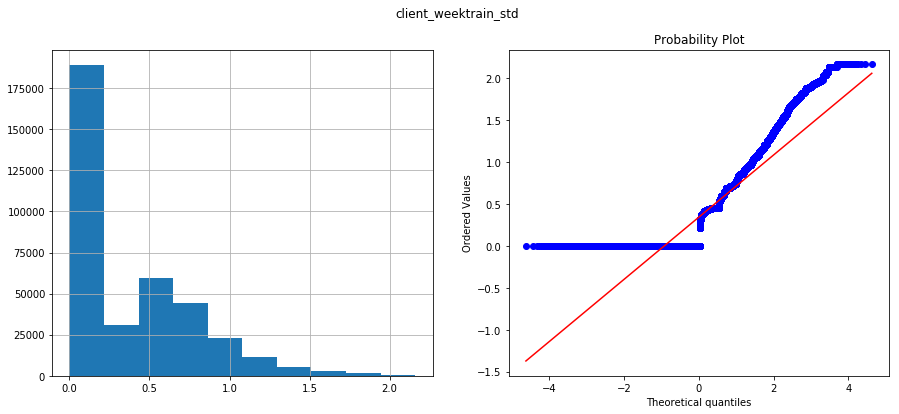

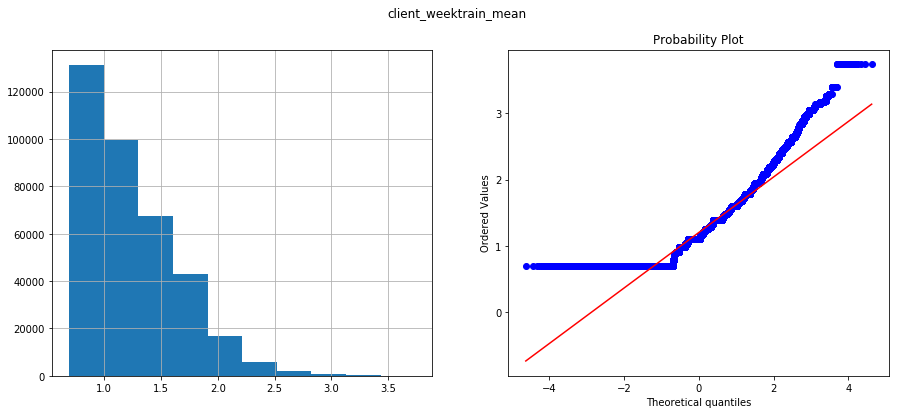

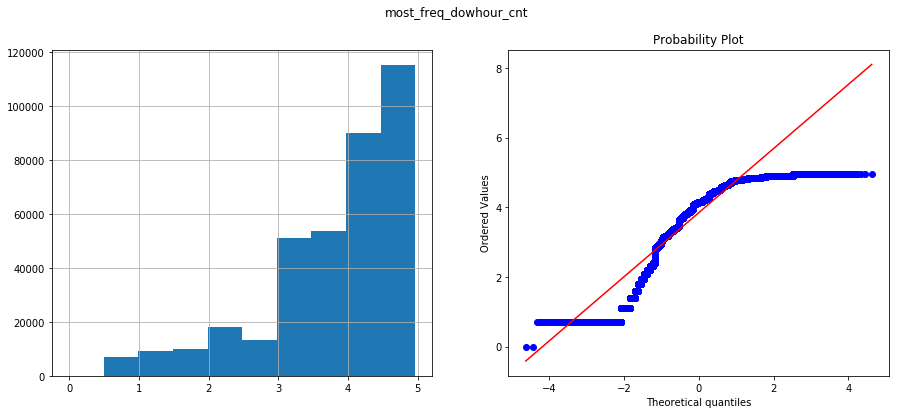

In [155]:
cols = [col for col in real_feats if train_df[col].nunique()>100]
for var in cols:
    diagnostic_plots(df_logtransform, var)

## Handling categorical features

In [33]:
df_all_cats = create_partial_df_all(train_df, cat_feats, test_df)

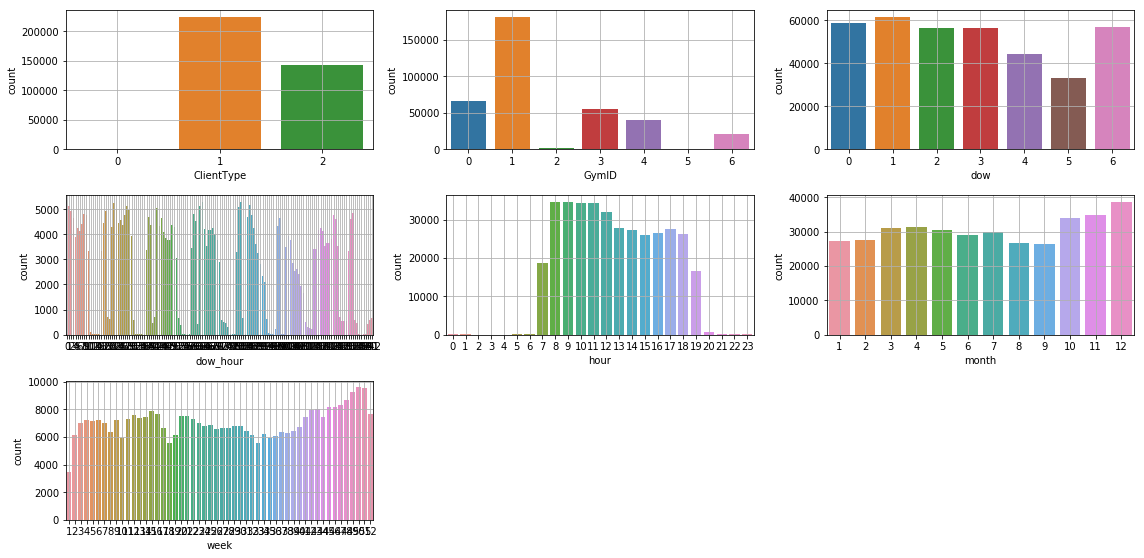

In [161]:
plt.figure(figsize=[16,10])
for i, cat in enumerate(cat_feats):
    ax = plt.subplot(4, 3, i + 1)
    sns.countplot(df_all_cats[cat], ax=ax)
    plt.grid()
    plt.tight_layout()

In [166]:
pd.crosstab(train_df.ClientType, train_df.Target, margins=True)

Target,0,1,All
ClientType,,,
0,62,89,151
1,8421,183907,192328
2,4489,124199,128688
All,12972,308195,321167


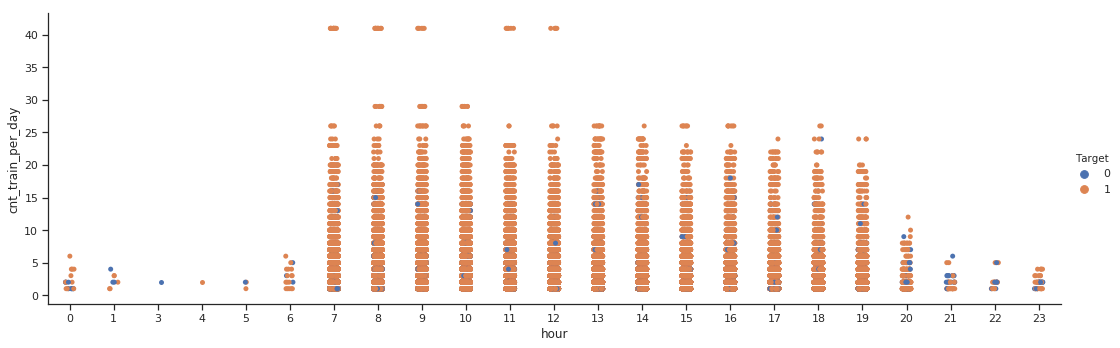

In [168]:
sns.set(style="ticks")
g = sns.catplot(x="hour", y="cnt_train_per_day", hue="Target", data=train_df, aspect=3);

In [ ]:
cols = [col for col in real_feats if train_df[col].nunique()>100]+["Target"]
sns.pairplot(train_df, vars=cols, diag_kind="kde", hue="Target")

# Feature selection

In [169]:
from boruta import BorutaPy

In [15]:
Y = train_df.Target.values
X = pd.concat([df_all_cats, df_all_numeric], axis=1)[:len(Y)].values
X.shape, len(Y)

((321167, 25), 321167)

In [174]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=4, max_depth=5)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=0)
boruta_selector.fit(X, Y)

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=132, n_jobs=4,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7FFAE8D72E20,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_stat

In [176]:
feature_df = pd.DataFrame(pd.concat([df_all_cats, df_all_numeric], axis=1)[:len(Y)].columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))
feature_df.to_csv(PATH_TO_DATA/'boruta-feature-ranking.csv', index=False)


 Top 22 features:
                           features  rank
0                        ClientType     1
1              client_weektrain_std     1
2               cnt_clients_per_gym     1
3               cnt_coaches_per_gym     1
4          cnt_ClientType_per_coach     1
5                    time_value_cnt     1
6             cnt_groups_gymID_time     1
7                 cnt_train_per_day     1
8        cnt_days_before_last_train     1
9                pct_order_ClientID     1
10  invert_order_of_visits_ClientID     1
11         order_of_visits_ClientID     1
12         cnt_traintype_per_client     1
13             cnt_coach_per_client     1
14              cnt_gyms_per_client     1
15                       cnt_visits     1
16                         dow_hour     1
17                             hour     1
18                             week     1
19                            GymID     1
20            client_weektrain_mean     1
21            most_freq_dowhour_cnt     1


In [184]:
del df_boxcox, df_logtransform
gc.collect()

164336

# Weights selection

In [16]:
from sklearn.utils.class_weight import compute_sample_weight

In [185]:
boruta_feats = pd.read_csv(PATH_TO_DATA/"boruta-feature-ranking.csv", usecols=['features'])

In [ ]:
drop_corr_cols(train_df)

In [215]:
Y = train_df.Target.values
X = pd.concat([df_all_cats, df_all_numeric], axis=1).loc[:len(Y), boruta_feats.features.values.tolist()].values
X.shape, len(Y)

((321168, 24), 321167)

In [18]:
def mean_cv_score(estimator, features, labels, weights=None, metric_name="roc_auc"):
    return round(np.mean(cross_val_score(
        estimator=estimator,
        X=features,
        y=labels,
        scoring=metric_name,
        cv=skf,
       # n_jobs=-1,
        fit_params={"sample_weight": weights}
    )), 4)

clf = LGBMClassifier(random_state=SEED)

In [19]:
# BASE SCORE
weights_equal = compute_sample_weight(class_weight=None, y=Y)
mean_cv_score(clf, X, Y, weights_equal)

0.7906

In [20]:
# balanced weights: 50/50
weights_balanced = compute_sample_weight(class_weight="balanced", y=Y)
mean_cv_score(clf, X, Y, weights_balanced)

0.7851

In [21]:
# 75/25
unique_weights_balanced = np.unique(weights_balanced)

weights_75_25 = compute_sample_weight(
    class_weight={0: unique_weights_balanced[0] * (75/50),
                  1: unique_weights_balanced[1] * (25/50)},
                  y=Y )

mean_cv_score(clf, X, Y, weights_75_25)

0.7865

In [22]:
# 90/10
weights_90_10 = compute_sample_weight(
    class_weight={0: unique_weights_balanced[0] * (90/50),
                  1: unique_weights_balanced[1] * (10/50)},
                  y=Y )

mean_cv_score(clf, X, Y, weights_90_10)

0.7888

In [42]:
cols_with_rare = ["GymID", "hour", "CoachID", "TrainingID", "ClientType"]
cols_high_cardinality = ["CoachID", "TrainingID"]
to_ohe = ["ClientType", "GymID", "dow", "hour", "month"] # "is_holiday"
to_scale = np.setdiff1d(cat_feats, to_ohe).tolist()

def model_assessment(estimator, X, y, cv=skf, seed=SEED, test_size=0.3, weights=None):    
    estimator1 = deepcopy(estimator)
    estimator2 = deepcopy(estimator)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, 
                                                          random_state=seed, stratify=y)
    
    def roc_auc_score_task():
        return roc_auc_score(y_valid, estimator2.fit(X_train, y_train).predict_proba(X_valid)[:, 1])    
    
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        roc_auc_score_future = executor.submit(roc_auc_score_task)            # n_jobs=-1
        return cross_val_score(estimator1, X_train, y_train, scoring='roc_auc', cv=cv)\
               .mean(), roc_auc_score_future.result()

In [58]:
Y = train_df.Target
X = pd.concat([df_all_cats, df_all_numeric], axis=1)[:len(Y)]
X[cat_feats] = X[cat_feats].astype("O")
X.shape, len(Y)

((321167, 27), 321167)

In [43]:
# logreg pipeline
logreg_pipe = pipe([

    ('ohe', ce.OneHotCategoricalEncoder(drop_last=True, variables=to_ohe) ), 
    ('rare', ce.RareLabelCategoricalEncoder(tol=0.05, n_categories=10, variables=to_scale) ),
    ('woe', ce.WoERatioCategoricalEncoder(encoding_method='woe', variables=to_scale) ),
#     ('categorical_encoder', ce.MeanCategoricalEncoder(variables = cat_feats)),
    ('outlier', outr.Winsorizer(distribution='gaussian', tail='both', fold=3, variables=real_feats) ),
    ('scale', RobustScaler() ),
    # model
    ('lr_model', LogisticRegression(solver='lbfgs', random_state=SEED) )
])

model_assessment(logreg_pipe, X, Y)

(0.7106200226293121, 0.7112734961093334)

In [44]:
# logreg pipeline: weights 20/80
logreg_weights_pipe = pipe([

    ('ohe', ce.OneHotCategoricalEncoder(drop_last=True, variables=to_ohe) ), 
    ('rare', ce.RareLabelCategoricalEncoder(tol=0.05, n_categories=10, variables=to_scale) ),
    ('woe', ce.WoERatioCategoricalEncoder(encoding_method='woe', variables=to_scale) ),
    ('outlier', outr.Winsorizer(distribution='gaussian', tail='both', fold=3, variables=real_feats) ),
    ('scale', RobustScaler() ),
    # model
    ('lr_model', LogisticRegression(solver='lbfgs', class_weight={0: 0.2, 1: 0.8}, random_state=SEED) )
])

model_assessment(logreg_weights_pipe, X, Y)

(0.710518076197474, 0.7111614217671571)

In [53]:
Y = train_df.Target
X = pd.concat([df_all_cats, df_all_numeric], axis=1)[:len(Y)]
X[to_scale] = X[to_scale].astype("O")

In [64]:
lgb_pipe = pipe([ 
    ('ohe', ce.OneHotCategoricalEncoder(drop_last=True, variables=to_ohe) ), 
    ('rare', ce.RareLabelCategoricalEncoder(tol=0.05, n_categories=10, variables=to_scale) ),
    ('mce', ce.MeanCategoricalEncoder(variables=to_scale) ),
    ('vt', vt.LogTransformer(variables=real_feats)),
    # model
    ('lgb', LGBMClassifier(random_state=SEED))
     ])

model_assessment(lgb_pipe, X, Y)

(0.7902273006700604, 0.790186132556163)

In [66]:
Y = train_df.Target
X = pd.concat([df_all_cats, df_all_numeric], axis=1)[:len(Y)]

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
tree_based_model_compare(X, Y, cv=skf, seed=SEED, score='roc_auc')

[RandomForestClassifier...] done in 209 s
[LGBMClassifier...] done in 12 s
[XGBClassifier...] done in 51 s
[CatBoostClassifier...] done in 216 s


,RF,LGB,XGB,CAT
0,0.845416,0.825699,0.781008,0.834095
1,0.847717,0.832135,0.784658,0.840740
2,0.846533,0.825295,0.778604,0.833394
3,0.845976,0.820079,0.777747,0.829992
4,0.844876,0.824762,0.779521,0.831823
,RF,LGB,XGB,CAT
count,5.000000,5.000000,5.000000,5.000000
mean,0.846103,0.825594,0.780308,0.834009
std,0.001093,0.004301,0.002715,0.004081
min,0.844876,0.820079,0.777747,0.829992


# Final single model - lgbm

In [ ]:
import category_encoders as cat_enc
from feature_engine import categorical_encoders as ce
import random

In [75]:
def preprocessing_drop_11_12_month(train, test):
    
    df = train.copy()[~train.month.isin([11, 12])]
    dft = test.copy()
    
    to_object = ['dow_hour', 'most_freq_dowhour_cnt'] #'CoachID', 'TrainingID'
    df[to_object] = df[to_object].astype('O')
    dft[to_object] = dft[to_object].astype('O')
    rare_encoder = ce.RareLabelCategoricalEncoder(tol=0.001, 
                                                  n_categories=10,
                                                  variables=to_object)

    rare_encoder.fit(df[to_object])
    # transform the data
    df[to_object]= rare_encoder.transform(df[to_object])
    dft[to_object]= rare_encoder.transform(dft[to_object])
       
    test_coachID_only = np.setdiff1d(dft.CoachID.unique(), df.CoachID.unique())
    test_TrID_only = np.setdiff1d(dft.TrainingID.unique(), df.TrainingID.unique())
    df_all = pd.concat([df.drop("Target", axis=1), dft]).reset_index(drop=True)

    df_all.loc[df_all.CoachID.isin(test_coachID_only), 'CoachID'] = -999
    df_all.loc[df_all.TrainingID.isin(test_TrID_only), 'TrainingID'] = -999
    minor_CoachID = df_all.CoachID.value_counts()[(df_all.CoachID.value_counts() < 30)].index
    df_all.loc[df_all.CoachID.isin(minor_CoachID), 'CoachID'] = -777
    minor_TrainingID = df_all.TrainingID.value_counts()[df_all.TrainingID.value_counts() < 50].index
    df_all.loc[df_all.TrainingID.isin(minor_TrainingID), 'TrainingID'] = -777
    df_all["CoachID"] = LabelEncoder().fit_transform(np.ravel(df_all["CoachID"]))
    df_all["TrainingID"] = LabelEncoder().fit_transform(np.ravel(df_all["TrainingID"]))
    # log freq encod
    df_all["dow_hour_log_freq"] = df_all.dow_hour.map(np.log(df_all.dow_hour.value_counts(normalize=True) * 100)) 
    df_all["dowhour_most_log_freq"] = df_all.most_freq_dowhour_cnt.map(np.log(df_all.most_freq_dowhour_cnt.value_counts(normalize=True) * 100))
    df_all["CoachID_log_freq"] = df_all.CoachID.map(np.log(df_all.CoachID.value_counts(normalize=True) * 100))
    df_all["TrainingID_log_freq"] = df_all.TrainingID.map(np.log(df_all.TrainingID.value_counts(normalize=True) * 100))

    # === split
    df_he = df_all[:len(df)]
    dft_he = df_all[len(df):].reset_index(drop=True)
         
    to_drop = ['Id', 'ClientID'] + to_object 
    y = df.sort_values("Id")[["ClientID", "Target"]].reset_index(drop=True)
    X_train = df_he.sort_values("Id").drop(to_drop, axis=1).reset_index(drop=True)
    X_test = dft_he.sort_values("Id").drop(to_drop, axis=1).reset_index(drop=True)
    
    # ==== scale
    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train_scale = scaler.transform(X_train)
    X_test_scale = scaler.transform(X_test)
    print(X_train_scale.shape, X_test_scale.shape, len(y))
    
    del df, dft, dft_he, df_he, df_all
    gc.collect()
    
    # split'll run by ClientID wile 
    X_train = pd.concat([pd.DataFrame(X_train_scale, columns=X_train.columns), y], axis=1)
    
    return X_train, pd.DataFrame(X_test_scale, columns=X_test.columns)

In [76]:
%%time
X_train, X_test = preprocessing_drop_11_12_month(train_df, test_df)

(247812, 29) (46259, 29) 247812
CPU times: user 774 ms, sys: 21 ms, total: 795 ms
Wall time: 747 ms


In [108]:
Xtrain, Xtest = train_test_split(X_train, stratify=X_train.Target, test_size=.25, random_state=SEED)
y_test = Xtest.pop("Target")
Xtrain.shape, Xtest.shape, len(y_test)

((185859, 31), (61953, 30), 61953)

In [116]:
Xtrain.reset_index(drop=True, inplace=True)
Xtest.reset_index(drop=True, inplace=True)

In [103]:


def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum([x for x in y_distr.values()])
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

def stratified_group_k_fold(X, y, groups, k, seed=None):
    """
    Source: https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    """
    
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices


def train_model_classification_stratified_group_k_fold_split(X, 
                                                             X_test, params, 
                                                             folds=5, 
                                                             model_type='lgb', 
                                                             eval_metric='auc',
                                                             columns=None, 
                                                             plot_feature_importance=False, 
                                                             model=None,
                                                             verbose=10000, 
                                                             early_stopping_rounds=200, 
                                                             n_estimators=1500):
    
    """
    Source: https://www.kaggle.com/artgor
    """
  
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(X.Target.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    groups = np.array(X.ClientID.values)
    
    # split and train on folds
    for fold_n, (train_id, valid_id) in enumerate(stratified_group_k_fold(X.drop("Target", axis=1), 
                                                                                 X.Target.values, 
                                                                                 groups, k=folds)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        train_index = X.loc[X.ClientID.isin(train_id), :].index
        valid_index = X.loc[X.ClientID.isin(valid_id), :].index
        
        X_train, X_valid = X.loc[train_index, columns], X.loc[valid_index, columns]
        y_train, y_valid = X.loc[train_index, "Target"], X.loc[valid_index, "Target"]
        
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_jobs = -1, n_estimators=n_estimators) 
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist,
                              early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)[:, 1]
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit) [:, 1]
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params) #iterations=n_estimators
                                      #loss_function='CrossEntropy') #  metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=True, use_best_model=True, verbose=False) # cat_features=cats_indices

            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
    
    prediction /= folds
   
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

params_ = {'boosting': 'gbdt',
          'objective':'binary',
          'metric': 'auc',
          'learning_rate': 0.01, 
          'num_leaves': 110, 
          'max_bin': 66, 
          'max_depth': 10,
          'min_data_in_leaf': 30,
          'min_child_samples': 20,
          'feature_fraction': 0.5,
          'bagging_fraction': 0.8,
          'bagging_freq': 40,
          'bagging_seed': 11,
          'lambda_l1': 2,
          'lambda_l2': 0.1,
          'random_state': SEED}

Fold 1 started at Sun Mar  8 13:56:17 2020
Fold 2 started at Sun Mar  8 13:57:15 2020
Fold 3 started at Sun Mar  8 13:57:59 2020
Fold 4 started at Sun Mar  8 13:58:27 2020
Fold 5 started at Sun Mar  8 13:59:11 2020
CV mean score: 0.7967, std: 0.0090.


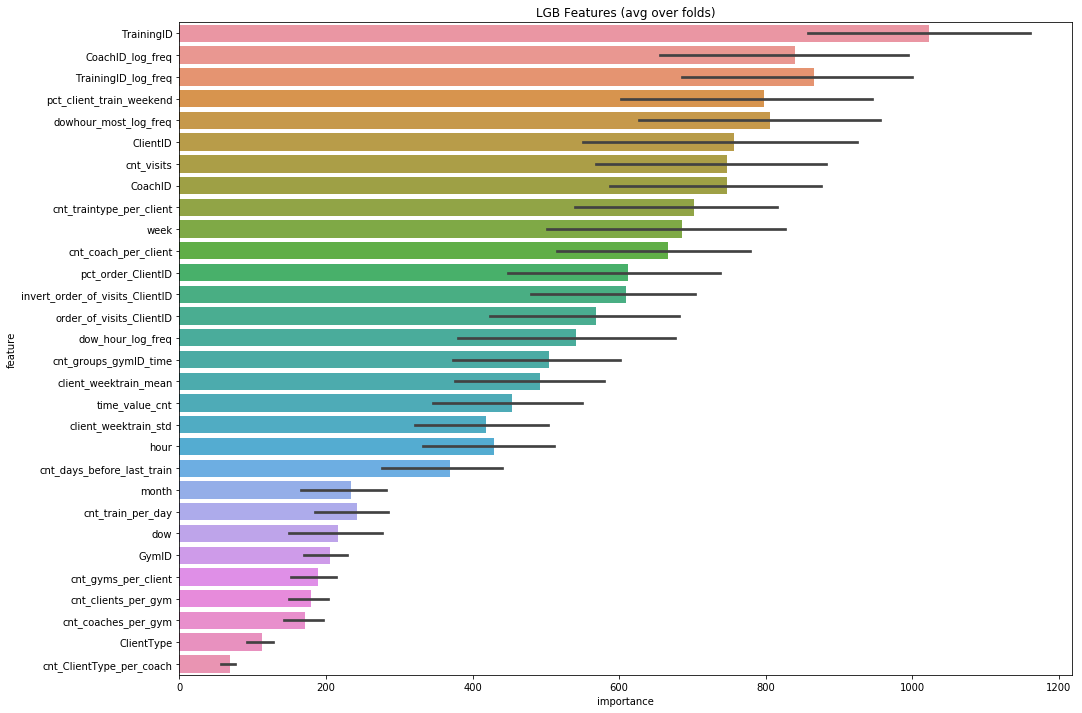

In [117]:
lgb_res=train_model_classification_stratified_group_k_fold_split(Xtrain, Xtest, params=params_, 
                                                                 columns=Xtest.columns.tolist(), 
                                                                 plot_feature_importance=True, verbose=0)

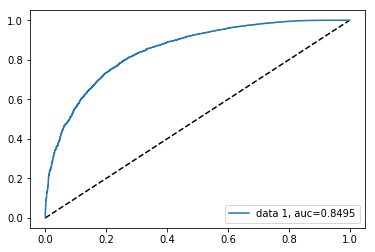

In [122]:
plot_roc(y_test, lgb_res['prediction'][:, 1])

In [125]:
# Train split stategy

train_x = X_train.drop("Target", axis=1)
train_y = X_train.Target.values
groups = np.array(X_train.ClientID.values)

distrs = [get_distribution(train_y)]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    dev_y, val_y = train_y[dev_ind], train_y[val_ind]
    dev_groups, val_groups = groups[dev_ind], groups[val_ind]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_y) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,3.94%,96.06%
development set - fold 0,3.94%,96.06%
validation set - fold 0,3.93%,96.07%
development set - fold 1,3.93%,96.07%
validation set - fold 1,3.94%,96.06%
development set - fold 2,3.94%,96.06%
validation set - fold 2,3.93%,96.07%
development set - fold 3,3.93%,96.07%
validation set - fold 3,3.94%,96.06%
development set - fold 4,3.94%,96.06%


Fold 1 started at Sun Mar  8 14:23:15 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[521]	training's auc: 0.906407	training's auc: 0.906407	valid_1's auc: 0.809313	valid_1's auc: 0.809313
Fold 2 started at Sun Mar  8 14:23:58 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.942997	training's auc: 0.942997	valid_1's auc: 0.806417	valid_1's auc: 0.806417
Early stopping, best iteration is:
[806]	training's auc: 0.931034	training's auc: 0.931034	valid_1's auc: 0.80755	valid_1's auc: 0.80755
Fold 3 started at Sun Mar  8 14:24:58 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.942322	training's auc: 0.942322	valid_1's auc: 0.808525	valid_1's auc: 0.808525
Early stopping, best iteration is:
[1118]	training's auc: 0.948357	training's auc: 0.948357	valid_1's auc: 0.808916	valid_1's auc: 0.808916
Fold 4 started at Sun Mar  8 14:26:12 2020
Training until v

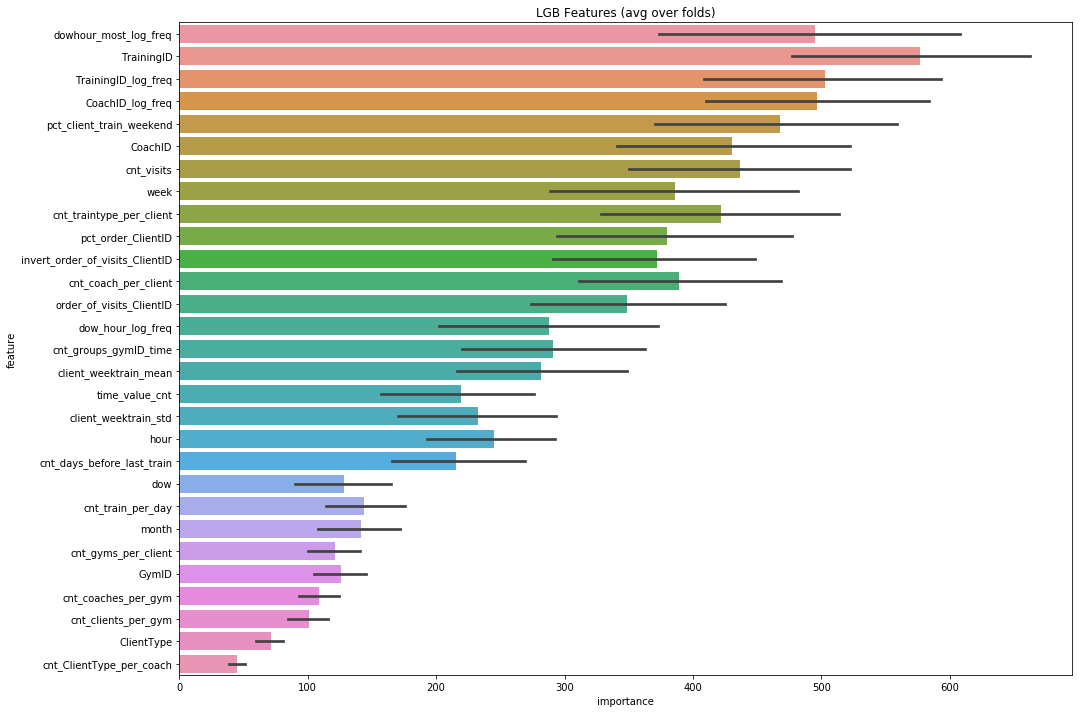

In [127]:
lgb_res=train_model_classification_stratified_group_k_fold_split(X_train, X_test, params=params_, folds=10, 
                                                                 columns=X_test.columns.tolist(), 
                                                                 plot_feature_importance=True, verbose=1000)

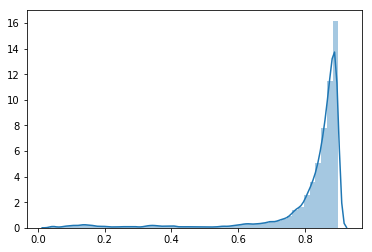

In [129]:
sns.distplot(lgb_res['prediction'][:, 1][lgb_res['prediction'][:, 1] < .9]);

In [130]:
subm = pd.read_csv(PATH_TO_DATA/'sample_submission.csv')
subm.Target = lgb_res['prediction'][:, 1]
subm.to_csv(PATH_TO_DATA/'sumbmission.csv', index=False)

In [132]:
!head -n7 $PATH_TO_DATA/sumbmission.csv

Id,Target
0,0.9402068946854285
1,0.9691128855670467
2,0.9069355389222444
3,0.9446591961998339
4,0.9532917697194595
5,0.9517326231268768


In [134]:
%cd  data
!kaggle  competitions  submit -c ml-posterior-gym-training-prediction -f sumbmission.csv\
    -m "lgb model"
%cd ..

/home/pchlq/workspace/kaggle/ml-posterior-gym-training-prediction/data
100%|███████████████████████████████████████| 1.09M/1.09M [00:05<00:00, 221kB/s]
Successfully submitted to ML Posterior. Gym training prediction/home/pchlq/workspace/kaggle/ml-posterior-gym-training-prediction


In [135]:
!kaggle competitions submissions -c ml-posterior-gym-training-prediction

fileName         date                 description  status    publicScore  privateScore  
---------------  -------------------  -----------  --------  -----------  ------------  
sumbmission.csv  2020-03-08 12:00:53  lgb model    complete  0.70236      None          
sumb20.csv       2020-03-07 12:56:09  None         complete  0.67854      None          
sumb19.csv       2020-03-07 12:20:09  None         complete  0.68973      None          
sumb18.csv       2020-03-06 20:44:07  None         complete  0.67843      None          
sumb17.csv       2020-03-06 17:26:11               complete  0.58876      None          
sumb16.csv       2020-03-06 17:13:25  None         complete  0.58882      None          
sumb15.csv       2020-03-06 14:26:19               complete  0.55945      None          
sumb14.csv       2020-03-06 14:19:36  None         complete  0.56548      None          
sumb13.csv       2020-03-05 08:45:42  None         complete  0.58783      None          
sumb12.csv       2020

# **Заключение**

1. Дополнительные признаки - офицальные празниные дни, а также признак выходного дня не улучшили модель.
2. В качестве итоговой сингл модели использовалась lgb - оптимальное соотношение качества и скорости из "деревянных" моделей.
3. Линейные/метрические модели можно пробовать использовать в качестве дополнительных, при этом они отличаются препроцессингом данных.
4. Особенностями данной задачи являются:
    - правильная кросс-валидация (чтобы клиенты с уникальными ид в трейн и тесте не пересекались)
    - в тестовой выборке присутсвуют наблюдения в ноябре и декабре; если их исключить, то скор улучшается.
    
На первых сабмитах использовались StratifiedKFold, TimeSeriesSplit - модель получалась бесполезной - в районе 0,5 и ниже. KFold давал прирост около 0.6. Лучший результат получился при правильной кросс-валидации на 10 фолдов. 

**Что можно попробовать**

5. В тестовой выборке данных по клиентам, посетившим тренировку 1 раз, сильно больше, чем в трейне. В этом смысле тренировочная выборка оказывается нерепрезентативной, т.е. паттерны, выявленные моделью по признакам, харатерным для клиентов с множеством посещений, на тесте не работали. Модель переобучается. Можно попробовать выровнять эту диспропоцию. 
6. Сильно улучшить модель можно генерацией дополнительных признаков, связанных со временем и подсчетом статистик.
7. Препроцессинг признаков (например TrainingID, CoachID) с использованием различных энкодеров, CountVectorizer, разреженных представлений и тд.
8. Нейросети, ансамбли моделей.

**Дополнительные данные, которые могут улучшить качество модели**

9. Расположение спорткомплесов, погодные условия (температура, влажность, атм.давление и тд), стоимость тренировки, возраст и гендер клиента.